In [2]:
#Import necessary modules
import pandas as pd
import numpy as np
import json
import string
import nltk
import spacy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.corpus import stopwords 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Create a joint DataFrame

In [3]:
# Create movie summaries dataframe
summaries = pd.read_csv('data/plot_summaries.txt', sep='\t', header=None, index_col=0)
summaries.columns = ['summary']
summaries

,summary
0,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...
...,...
34808485,"The story is about Reema , a young Muslim scho..."
1096473,"In 1928 Hollywood, director Leo Andreyev look..."
35102018,American Luthier focuses on Randy Parsons’ tra...


In [4]:
#create metadata dataframe and get title, language, genre data
meta = pd.read_csv('data/movie.metadata.tsv', sep='\t', index_col=0, header=None)
meta.drop([1,3,4,5,7], axis=1, inplace=True)
meta.columns = ['title', 'language', 'genre']
meta

,title,language,genre
0,,,
975900,Ghosts of Mars,"{""/m/02h40lc"": ""English Language""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,"{""/m/02h40lc"": ""English Language""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,Brun bitter,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
9363483,White Of The Eye,"{""/m/02h40lc"": ""English Language""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
261236,A Woman in Flames,"{""/m/04306rv"": ""German Language""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...
35228177,Mermaids: The Body Found,"{""/m/02h40lc"": ""English Language""}","{""/m/07s9rl0"": ""Drama""}"
34980460,Knuckle,"{""/m/02h40lc"": ""English Language""}","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
9971909,Another Nice Mess,"{""/m/02h40lc"": ""English Language""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"


In [5]:
# Join all data in a single df
df = pd.concat([summaries, meta], join='inner', axis=1)
df.head()

,summary,title,language,genre
0,,,,
23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/06b_j"": ""Russian Language""}","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/02h40lc"": ""English Language""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/0999q"": ""Malayalam Language""}","{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."
2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/02h40lc"": ""English Language""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/02h40lc"": ""English Language""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


### Extract language and genre information

In [6]:
df['language'] = df['language'].apply(lambda x: [*json.loads(x).values()]).apply(lambda x: x[0] if len(x)>0 else np.nan)

In [7]:
df['genre'] = df['genre'].apply(lambda x: [*json.loads(x).values()])

In [8]:
df.head()

,summary,title,language,genre
0,,,,
23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,Russian Language,"[Drama, World cinema]"
31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,English Language,"[Action/Adventure, Science Fiction, Action, Dr..."
20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,Malayalam Language,"[Musical, Action, Drama, Bollywood]"
2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,English Language,"[Screwball comedy, Comedy]"
595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,English Language,"[Crime Fiction, Drama, Docudrama, World cinema..."


### Inspect the Data

In [9]:
#Character count of plot summary
df['summary'].apply(len).agg(['max','mean','min'])

max     28159.000000
mean     1783.583594
min        99.000000
Name: summary, dtype: float64

In [10]:
#Word count of plot summary
df['summary'].str.split(' ').apply(len).agg(['max','mean','min'])

max     4942.000000
mean     312.223225
min        4.000000
Name: summary, dtype: float64

In [11]:
#Distribution of movie languages
df['language'].value_counts(normalize=True).head(10)

English Language      0.576015
Hindi Language        0.059421
French Language       0.051787
Japanese Language     0.032485
Tamil Language        0.027233
Silent film           0.022415
Italian Language      0.021630
Malayalam Language    0.020628
Spanish Language      0.018706
Korean Language       0.016080
Name: language, dtype: float64

Half of all movies are in English

## Preprocessing

Creating a text transformer module that can be applied as a pipeline object
This transformer truncates & lowercases the text, removes puncutation, stopwords and applies Lemmatization

In [12]:
class TextTransformer( BaseEstimator, TransformerMixin ):

    #Class Constructor
    def __init__( self, lemmatize=True, truncate=None):
        self.lemmatize = lemmatize
        self.nlp = spacy.load('en_core_web_sm')
        self.stopwords = stopwords.words('english')
        self.truncate = truncate

    #Return self
    def fit( self, X, y = None ):
        return self
    
    def load_normalizer( self):
        self.normalizer = TextNormalization()
        return self
    
    def truncate_string(self, s):
        s = str(s)
        if self.truncate is None:
            return s
        return s[:self.truncate].rsplit(' ', 1)[0]
    
    @staticmethod
    def remove_punctuation(s):
        return ''.join([c for c in s if c not in string.punctuation])

    def remove_stopwords(self, s):
        return ' '.join([w for w in s.split() if w not in self.stopwords])
    
    def lemma(self, x):
        txt = self.nlp(x)
        return ' '.join([w.lemma_ for w in txt])


    #Method that describes transformer actions
    def transform( self, X, y = None ):
        #Remove puncuation, lowercase, remove stopwords and truncate
        X = pd.Series(X)
        transformed = X.apply(self.truncate_string).apply(self.remove_punctuation).str.lower().apply(self.remove_stopwords)
        if self.lemmatize==True:
            transformed =  transformed.apply(self.lemma)
        return transformed

In [13]:
transformer = TextTransformer(truncate=1800)

In [ ]:
df['processed'] = transformer.fit_transform(df['summary'])

In [14]:
df.head()

,summary,title,language,genre,processed
0,,,,,
23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,Russian Language,"['Drama', 'World cinema']",shlykov hardworke taxi driver lyosha saxophoni...
31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,English Language,"['Action/Adventure', 'Science Fiction', 'Actio...",nation panem consist wealthy capitol twelve po...
20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,Malayalam Language,"['Musical', 'Action', 'Drama', 'Bollywood']",poovalli induchoodan sentence six year prison ...
2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,English Language,"['Screwball comedy', 'Comedy']",lemon drop kid new york city swindler illegall...
595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,English Language,"['Crime Fiction', 'Drama', 'Docudrama', 'World...",seventhday adventist church pastor michael cha...


## Vectorization

Create vector representation of text using Tfidf statistic

In [15]:
vectorizer = TfidfVectorizer()

In [16]:
summary_tm = vectorizer.fit_transform(df['processed'])

In [17]:
summary_tm

<42204x142682 sparse matrix of type '<class 'numpy.float64'>'
	with 3399418 stored elements in Compressed Sparse Row format>

## NMF (Non-Negative Matrix Factorization)

* This method finds two non negative matrices whose multiplication approximates the main dataset. 
* NMF is is used for dimensionality reduction and the feature/component matrices created can be used compare distance & similarity

In [18]:
from sklearn.decomposition import NMF
nmf_model = NMF(n_components = 100)
nmf_model.fit(summary_tm)

C:\Users\TCLSOYKAN\AppData\Roaming\Python\Python39\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(n_components=100)

In [19]:
nmf_features = nmf_model.transform(summary_tm)

In [20]:
nmf_features.shape

(42204, 100)

**NMF feature matrix consists of 42K rows for all movies and 100 features created by NMF**

In [21]:
nmf_model.components_.shape

(100, 142682)

**NMF components consist of 100 features in rows and all 142K tokens created by our vectorizer**

### Using NMF Feature Matrix for Similarities

* Since we have a 100 feature vector for each movie, we can get the similarity of a particular movie with other movies by matrix multiplication of that movie with whole feature matrix
* As we are using the vector distance, we should normalize all features so that similarities are calculated correctly

In [22]:
from sklearn.preprocessing import normalize
norm_features = normalize(nmf_features)

In [23]:
df_nmf = pd.DataFrame(norm_features, index=df['title'])
similarities = df_nmf.dot(df_nmf.loc['The Hunger Games'])

In [24]:
similarities.shape

(42204,)

**The resulting similarity matrix has a single similarity value for each movie

In [25]:
#The movies that have highest similarity value are most similar to The Hunger Games
similarities.nlargest(10)

title
The Hunger Games                                                             1.000000
The Tournament                                                               0.757485
Hercules                                                                     0.757151
Snow Prince                                                                  0.756673
Afterlife                                                                    0.752405
Virginia's Run                                                               0.748547
The Deaths of Ian Stone                                                      0.746254
L'étoile du nord                                                             0.735555
Doubletime                                                                   0.732263
Cho Kamen Rider Den-O & Decade NEO Generations: The Onigashima Battleship    0.728266
dtype: float64

### Pipeline for Recommendation of Similar Movies

* We can combine the text transformer, vectorizer and nmf model objects in a pipeline to get an NMF vector for any given plot.
* Then we can use this vector to calculate similarities in our feature matrix

In [26]:
nmf_pipeline = make_pipeline(transformer, vectorizer, nmf_model)

In [27]:
transformed = nmf_pipeline.transform('The Black Cat of Egypt ran quickly over the hill. He was getting ready for a fierce battle with Pharaoh')

In [28]:
similarities = df_nmf.dot(transformed.squeeze())

In [29]:
similarities.nlargest(10)

title
Taking the Blame          0.033686
Not Now                   0.033628
A Fractured Leghorn       0.033386
Louvre Come Back to Me    0.033268
Cool Cat                  0.032884
Evil Cat                  0.032610
Happy You and Merry Me    0.032607
Lorenzo                   0.032566
King-Size Canary          0.032515
Heathcliff: The Movie     0.032512
dtype: float64

## Inspecting NMF Features

**Here we select a random feature and use a wordcloud to visualize whether this created feature can have any interpretation**

In [31]:
#Select the first 20 movies that have highest value for the seventh feature
feature5 = df_nmf.iloc[:,6].nlargest(20)
feature5

title
13 Men and a Gun                                 0.967109
Fear and Desire                                  0.954274
Secret Agent X-9                                 0.943697
I Can't Go Home                                  0.936216
Shuva Ratri                                      0.927220
Hello, That's Me!                                0.920373
Chance of a Lifetime                             0.919690
Heimat                                           0.907158
Amphitryon                                       0.905658
Pierre Schoendoerffer, the Sentinel of Memory    0.898897
Eleftherios Venizelos                            0.893714
Fast Charlie... the Moonbeam Rider               0.889631
Blue Gold: World Water Wars                      0.887238
Cubers                                           0.884734
The Vicar of Bray                                0.884617
Code Name Melville                               0.882054
Man of Straw                                     0.878358
The Gent

In [32]:
#Get plot summaries for movies
title_df = df.set_index('title')
summaries = title_df.loc[feature5.index, 'processed']
summaries

title
13 Men and a Gun                                 first world war russian force attempt take aus...
Fear and Desire                                  fear desire open offscreen narrator tell audie...
Secret Agent X-9                                 side world war ii attempt control secret eleme...
I Can't Go Home                                  2006 lebanon war erupt lebanese filmmaker woma...
Shuva Ratri                                      2002 bloodiest civil war nepal wound rebellion...
Hello, That's Me!                                artyom manvelyan famous physicist founder cosm...
Chance of a Lifetime                             time austerity second world war fail factorys ...
Heimat                                           heimat 3 episode list happy people world world...
Amphitryon                                       amphitryon theban general away war god jupiter...
Pierre Schoendoerffer, the Sentinel of Memory    pierre schoendoerffer revisit life career stro...
Elef

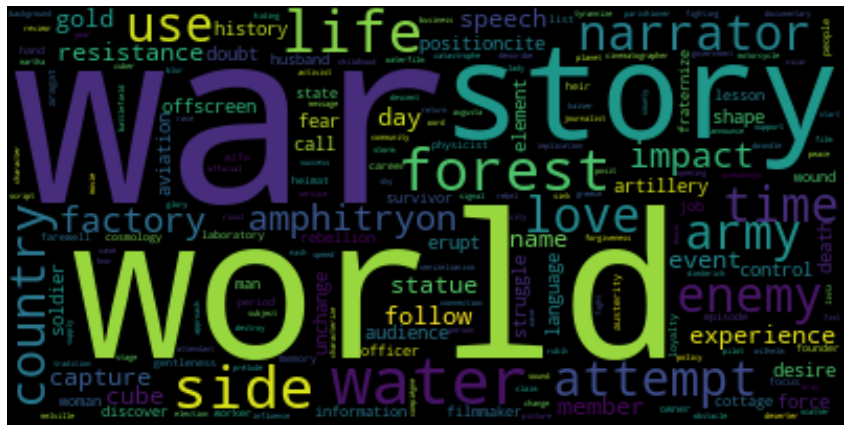

In [33]:
#use wordcloud to visualize the common nouns in these movies
from functools import reduce
text = reduce(lambda x,y: x+' '+y, summaries)


nlp = spacy.load('en_core_web_sm')
doc = nlp(text)
words = []
for w in doc:
     if w.pos_ == 'NOUN':
        words.append(w.text)
words = ' '.join(words)
    
wordcloud = WordCloud(collocations=False).generate(words)
    
# wordcloud = WordCloud(collocations=False).generate(text)

plt.figure(figsize=(15,15))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

* This feature seems to have information on movies about war, army, world, country etc. 
* Since NMF is calculated with a random initialization and optimization with a loss function, these features can be different another time we run NMF model.  